In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

### Created my own example which generates a list of coding questions and then chooses the hardest one among them :

In [4]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 5 sub-topics that are all related to this overall topic: {topic}."""
coding_question_prompt = """Generate a coding challenge or question related to {subject}."""
hardest_question_prompt = """Below are a bunch of coding questions about {topic}. Select the hardest one! Return the ID of the hardest one, starting 0 as the ID for the first question. Questions: \n\n  {questions}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Example usage: you can call these prompts with your inputs to generate sub-topics, coding questions, and select the hardest question


In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel


class Subjects(BaseModel):
    subjects: list[str]


class HardestQuestion(BaseModel):
    id: int


class OverallState(TypedDict):
    topic: str
    subjects: list
    questions: Annotated[list, operator.add]
    hardest_selected_question: str


In [6]:
def generate_subjects(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


In [7]:
from langgraph.types import Send

def continue_to_questions(state: OverallState):
    return [Send("generate_coding_question", {"subject": s}) for s in state["subjects"]]


used maps :

In [8]:
from typing_extensions import TypedDict
from pydantic import BaseModel

class QuestionState(TypedDict):
    subject: str

class CodingQuestion(BaseModel):
    question: str

def generate_coding_question(state: QuestionState):
    prompt = coding_question_prompt.format(subject=state["subject"])
    response = model.with_structured_output(CodingQuestion).invoke(prompt)
    return {"questions": [response.question]}


reduce :

In [9]:
hardest_question_prompt = """Below are a bunch of coding questions about {topic}. Select the hardest one! Return the ID of the hardest one, starting 0 as the ID for the first question. Questions: \n\n  {questions}"""

def hardest_question(state: OverallState):
    questions = "\n\n".join(state["questions"])
    prompt = hardest_question_prompt.format(topic=state["topic"], questions=questions)
    response = model.with_structured_output(HardestQuestion).invoke(prompt)
    return {"hardest_selected_question": state["questions"][response.id]}


compiled the graph and tried it out with different examples :

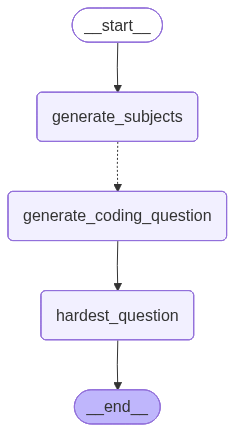

In [10]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START


# Construct the graph: integrating the entire coding question generation flow
graph = StateGraph(OverallState)
graph.add_node("generate_subjects", generate_subjects)
graph.add_node("generate_coding_question", generate_coding_question)
graph.add_node("hardest_question", hardest_question)
graph.add_edge(START, "generate_subjects")
graph.add_conditional_edges("generate_subjects", continue_to_questions, ["generate_coding_question"])
graph.add_edge("generate_coding_question", "hardest_question")
graph.add_edge("hardest_question", END)


# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())


In [11]:
# Call the graph: here we call it to generate a list of coding questions
for s in app.stream({"topic": "dsa"}):
    print(s)


{'generate_subjects': {'subjects': ['Data Structures', 'Algorithms', 'Complexity Analysis', 'Graph Theory', 'Dynamic Programming']}}
{'generate_coding_question': {'questions': ['### Coding Challenge: Implement a Custom Stack with Min Function\n\n#### Objective:\nCreate a custom stack data structure that supports the following operations efficiently:\n- **push(x)**: Push element x onto the stack.\n- **pop()**: Removes the element on top of the stack.\n- **top()**: Get the top element.\n- **getMin()**: Retrieve the minimum element in the stack.\n\nAll operations should be performed in constant time, O(1).\n\n#### Requirements:\n- Implement the stack using a class or a similar construct in your preferred programming language.\n- Ensure that the `getMin()` function returns the minimum element in the stack at any given time.\n- Handle edge cases such as calling `pop()` or `getMin()` on an empty stack gracefully.\n\n#### Example:\n```python\n# Example usage in Python\nstack = MinStack()\nsta

## Analysing this trace in the langsmith portal

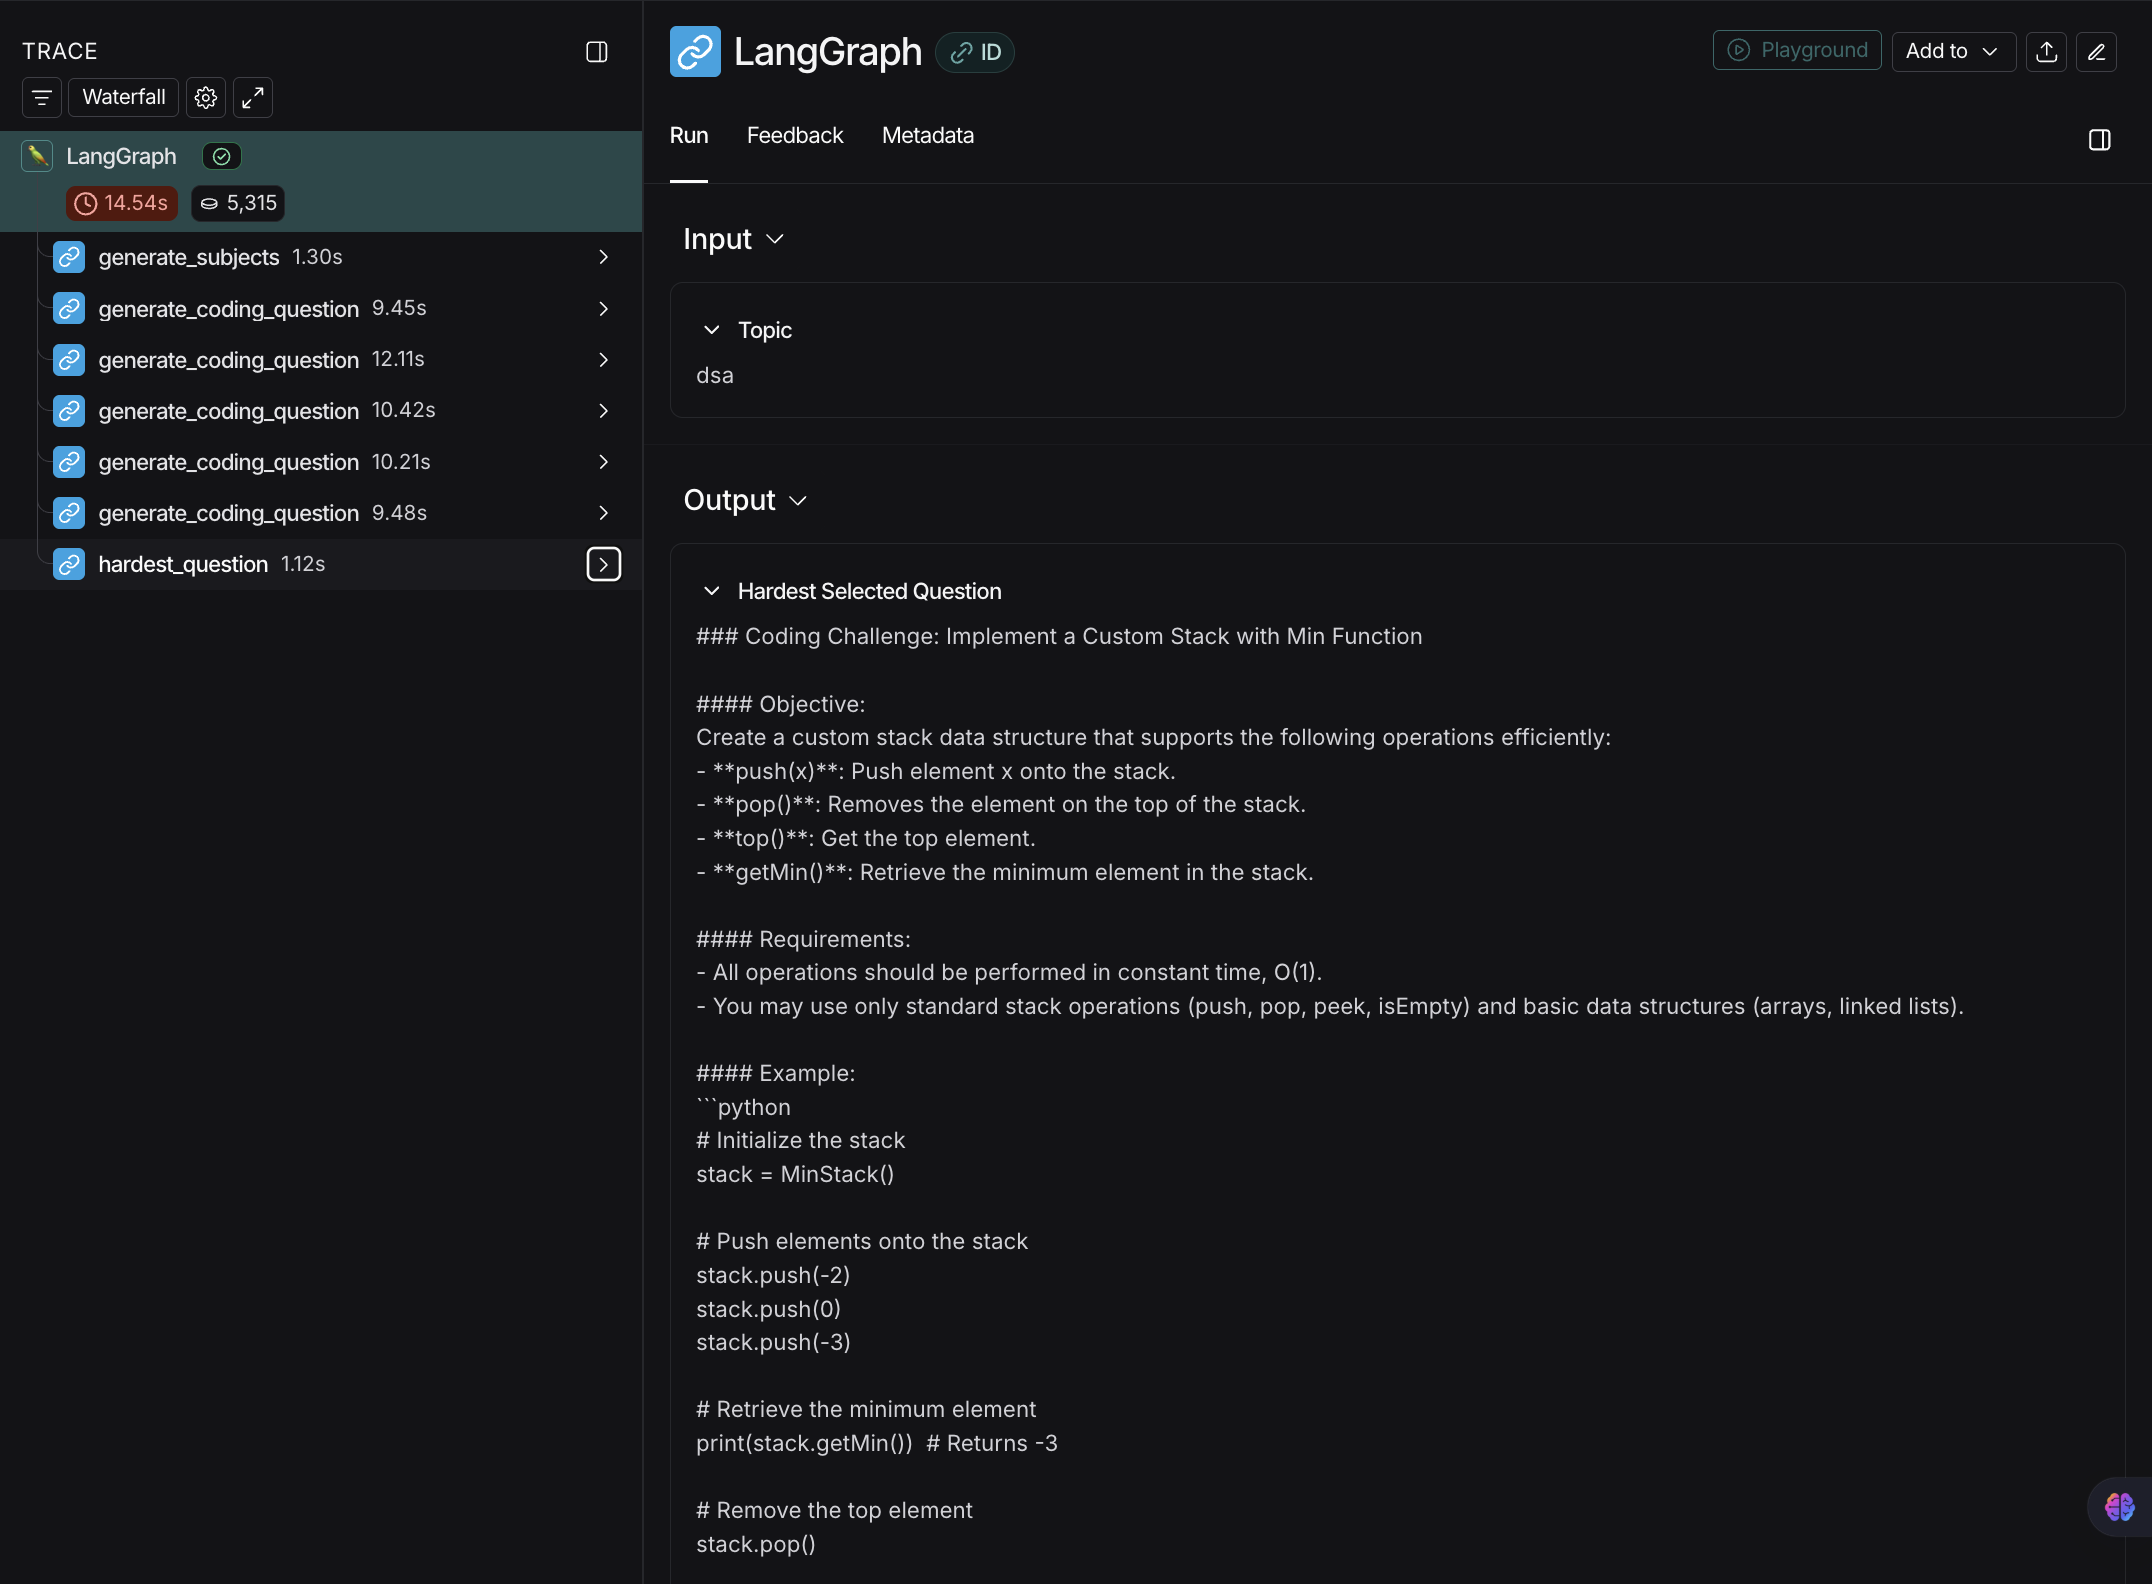

### we can see that this trace is very well organised and easy to undertand 

### we can expland individual elements and get a good look at whats going on inside :

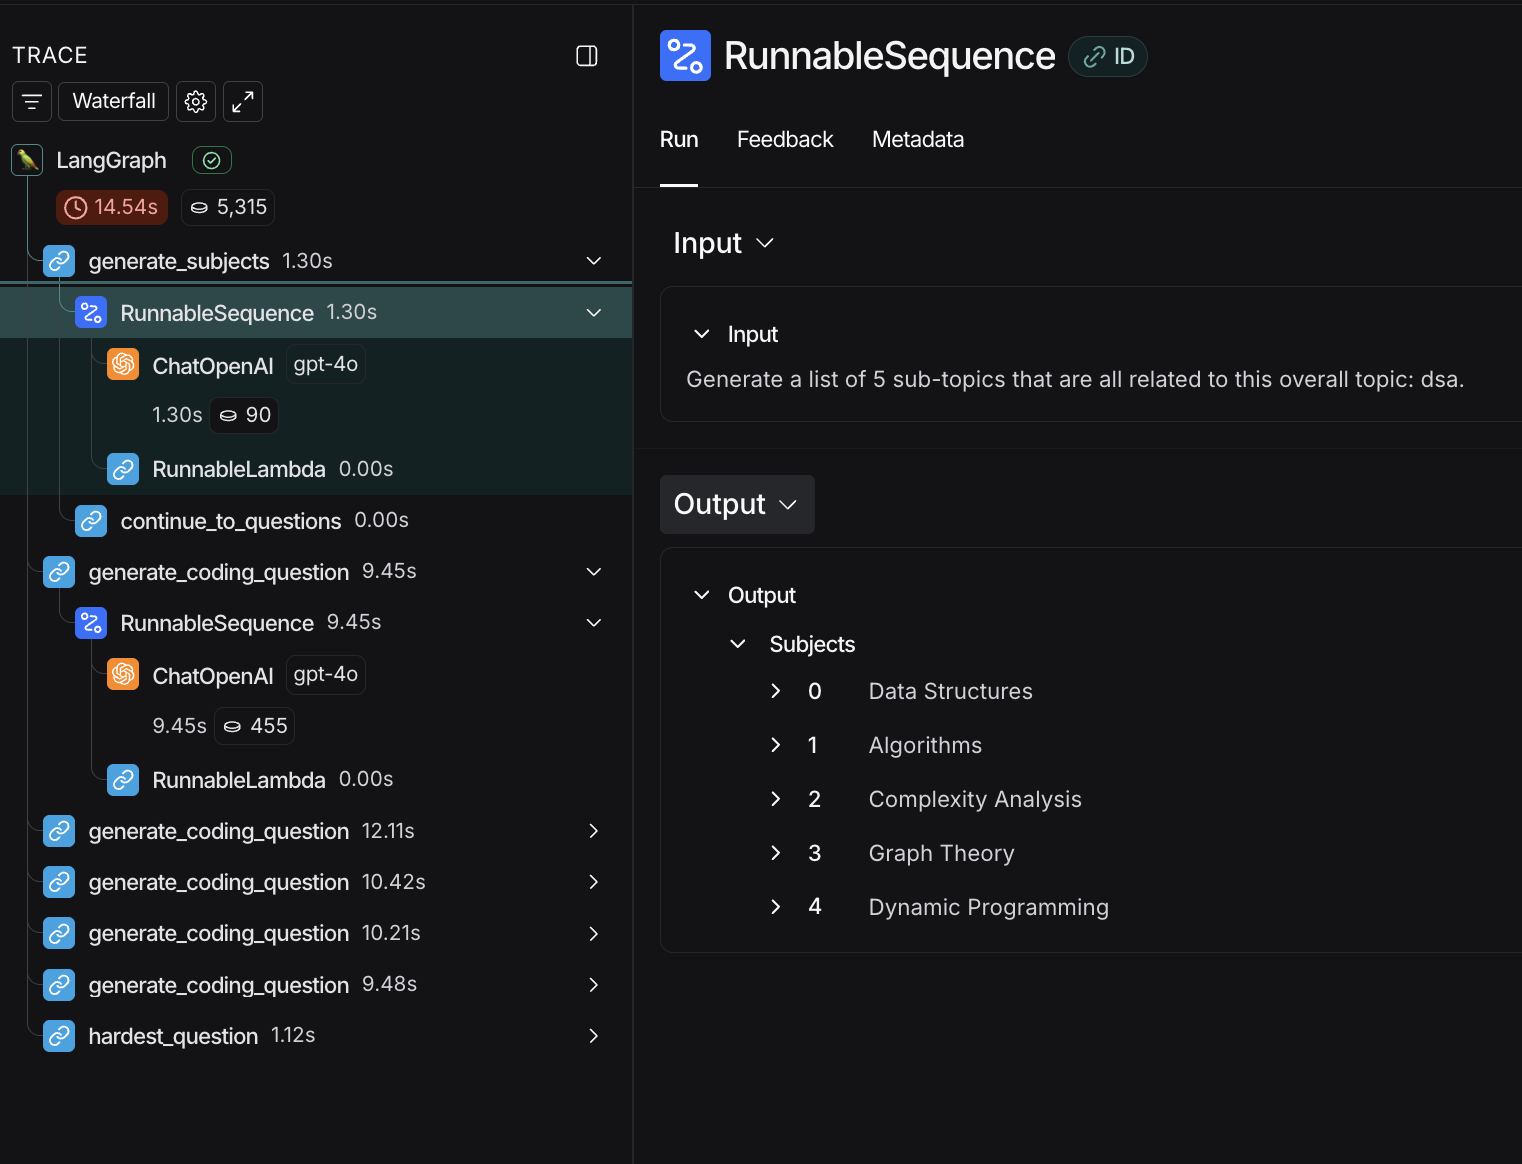

### tried it with other examples : 

In [12]:
# Call the graph: here we call it to generate a list of coding questions
for s in app.stream({"topic": "quant "}):
    print(s)
# 

{'generate_subjects': {'subjects': ['Quantitative Analysis in Finance', 'Quantitative Research Methods', 'Quantitative Data Analysis Tools', 'Quantitative Risk Management', 'Quantitative Trading Strategies']}}
{'generate_coding_question': {'questions': ['### Coding Challenge: Statistical Analysis of Financial Data\n\n#### Background:\nQuantitative research in finance often involves analyzing large datasets to identify patterns, trends, and relationships. One common task is to evaluate the performance of different financial assets over time and understand the factors influencing their returns.\n\n#### Task:\nYou are provided with a dataset containing daily closing prices of three different stocks over a period of one year. Your task is to perform a statistical analysis to determine the following:\n\n1. **Calculate Daily Returns:**\n   - Compute the daily returns for each stock. The daily return is calculated as the percentage change in the closing price from one day to the next.\n\n2. *

In [13]:
# Call the graph: here we call it to generate a list of coding questions
for s in app.stream({"topic": "cyber security "}):
    print(s)
# 

{'generate_subjects': {'subjects': ['Network Security', 'Cryptography', 'Cyber Threat Intelligence', 'Incident Response and Management', 'Data Privacy and Protection']}}
{'generate_coding_question': {'questions': ['### Cryptography Challenge: Implement a Simple Caesar Cipher\n\n#### Objective:\nCreate a program that implements a simple Caesar Cipher, a type of substitution cipher where each letter in the plaintext is shifted a certain number of places down the alphabet.\n\n#### Requirements:\n1. **Input:**\n   - A string of text (plaintext) to be encrypted.\n   - An integer value representing the shift (key) for the cipher.\n\n2. **Output:**\n   - The encrypted text (ciphertext) using the Caesar Cipher method.\n\n3. **Constraints:**\n   - The shift value can be any integer (positive or negative).\n   - The program should handle both uppercase and lowercase letters.\n   - Non-alphabetic characters should remain unchanged.\n\n4. **Bonus:**\n   - Implement a decryption function that takes

# LANGGRAPH STUDIO :

#### made this new map.py file to access the graph through langgraph studio :

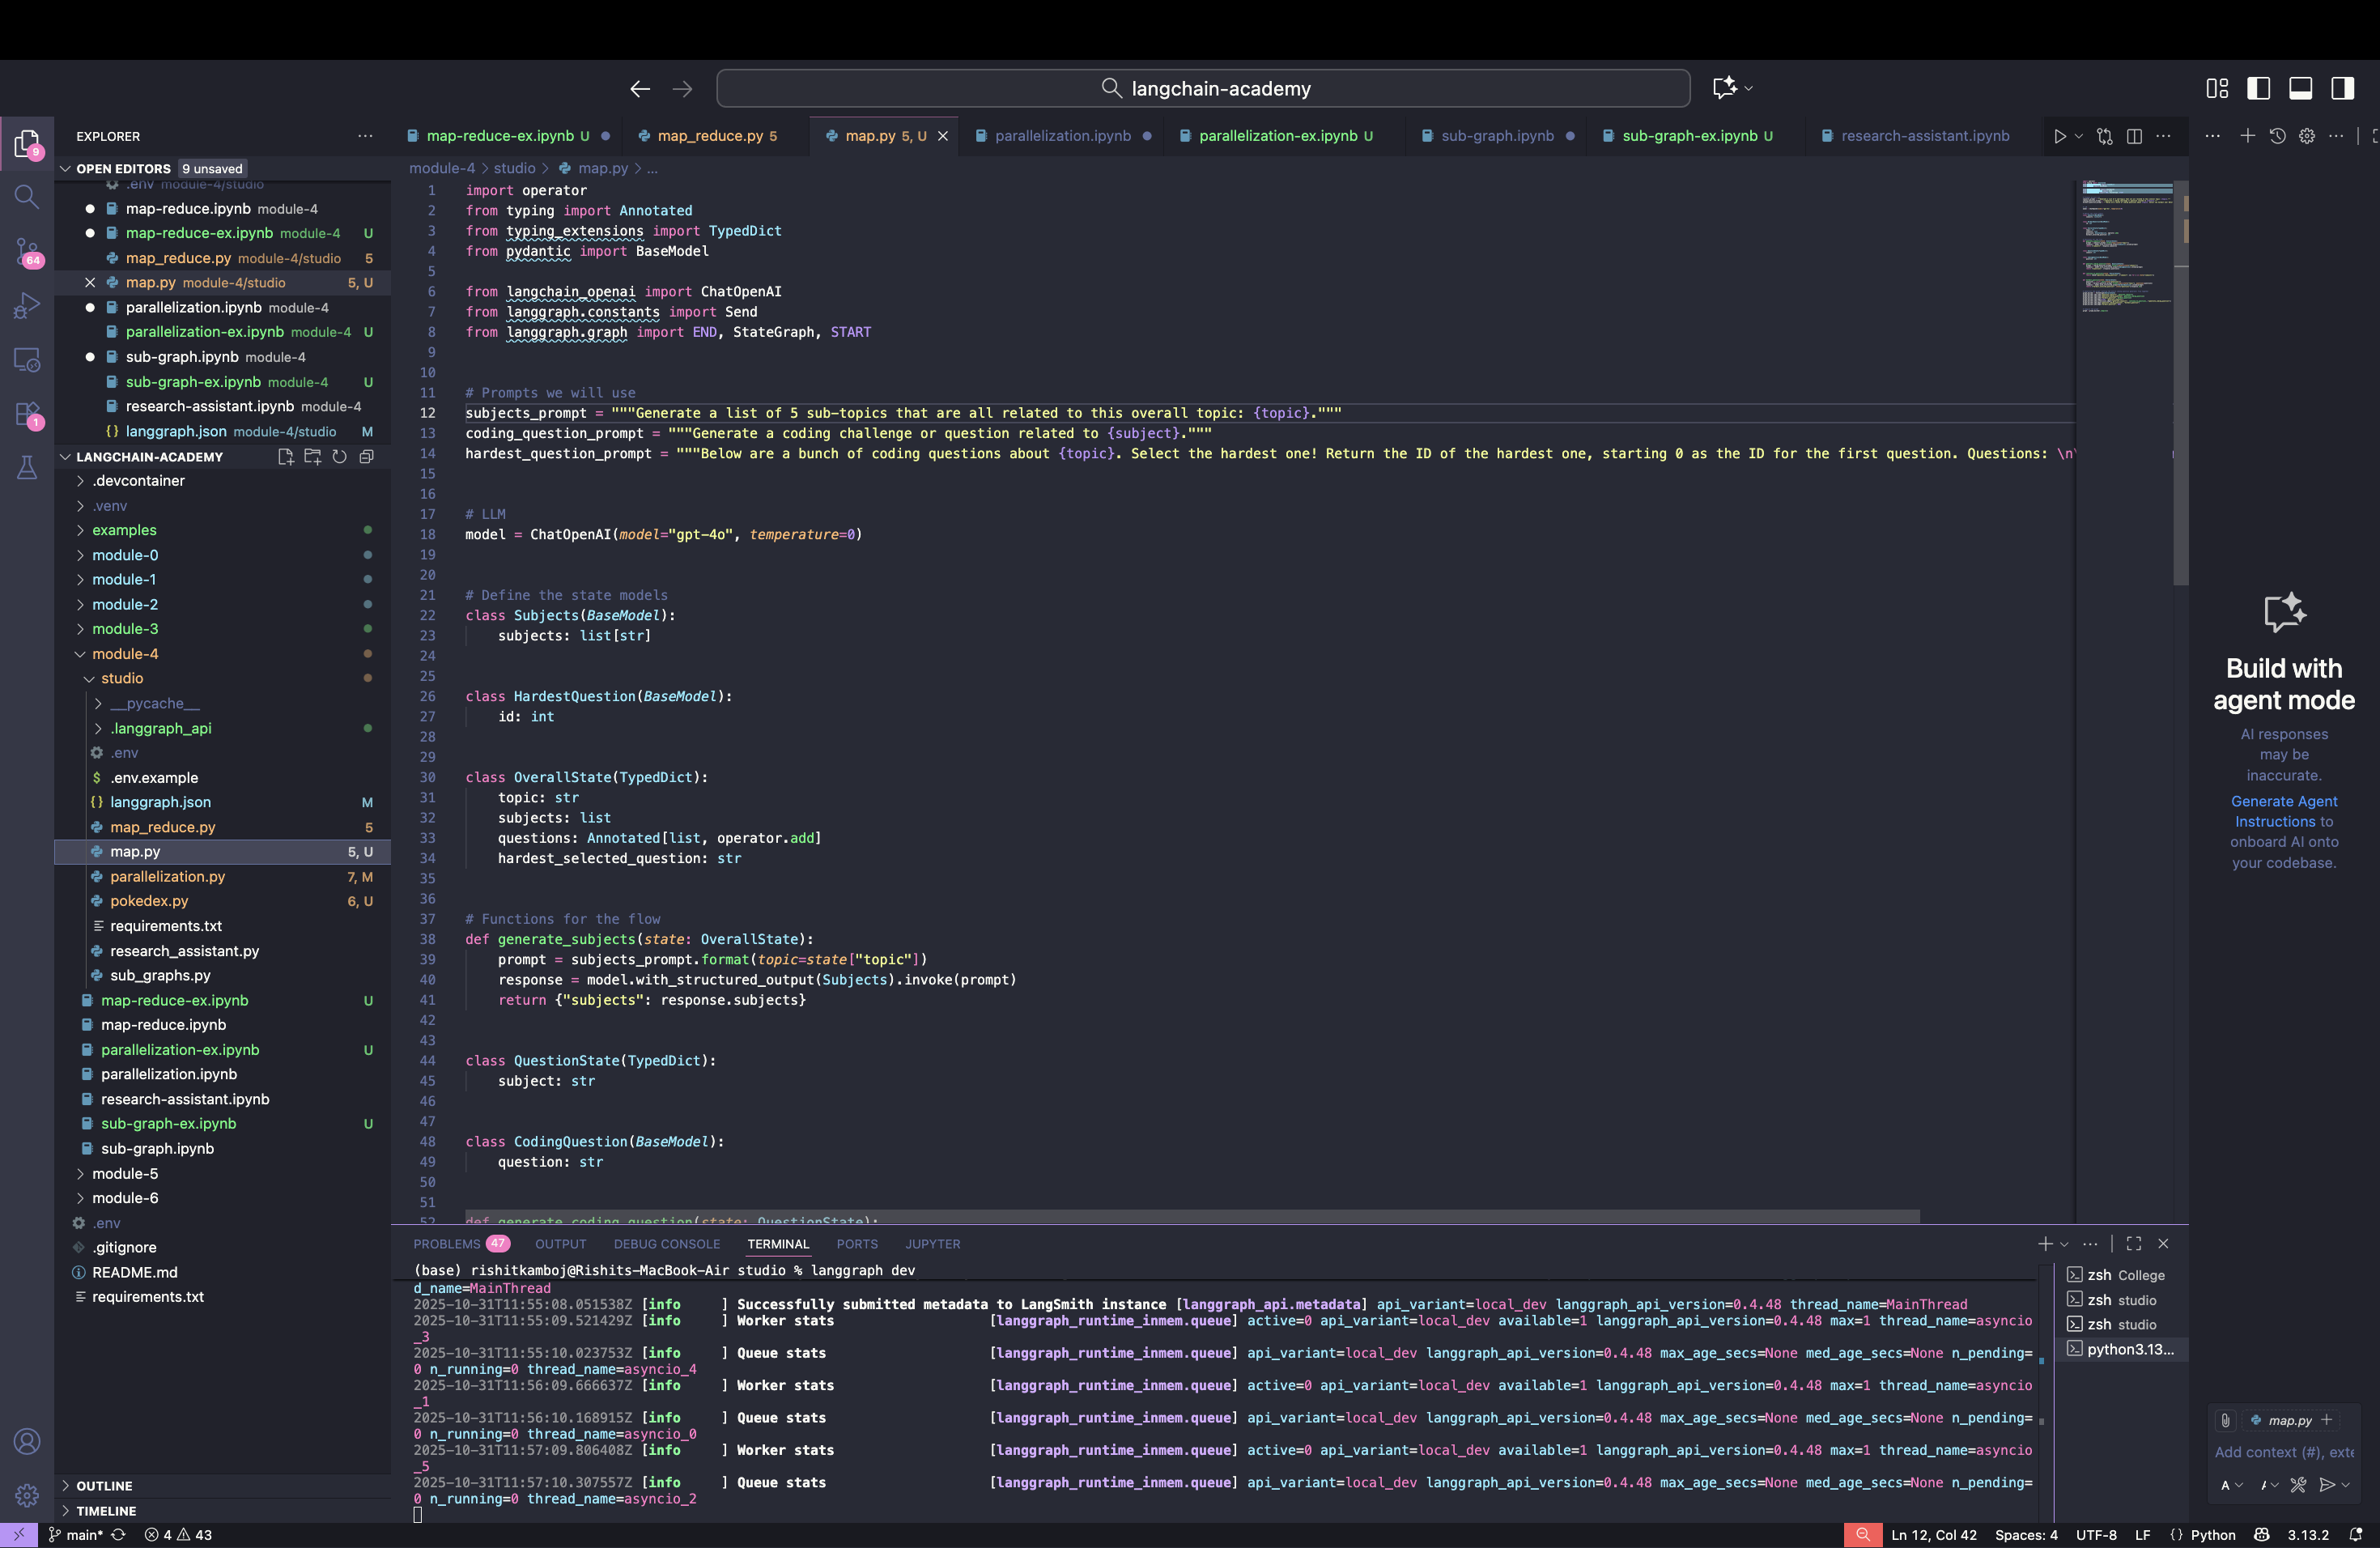

#### added it to the langgraph.json 
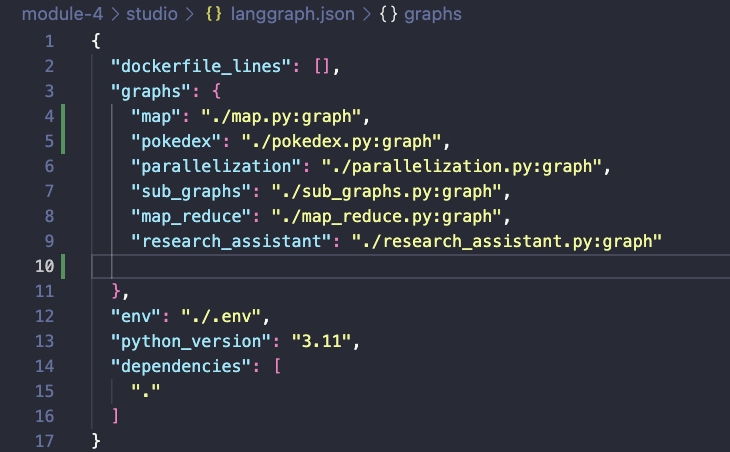

## IN THE LANGGRAPH STUDIO :

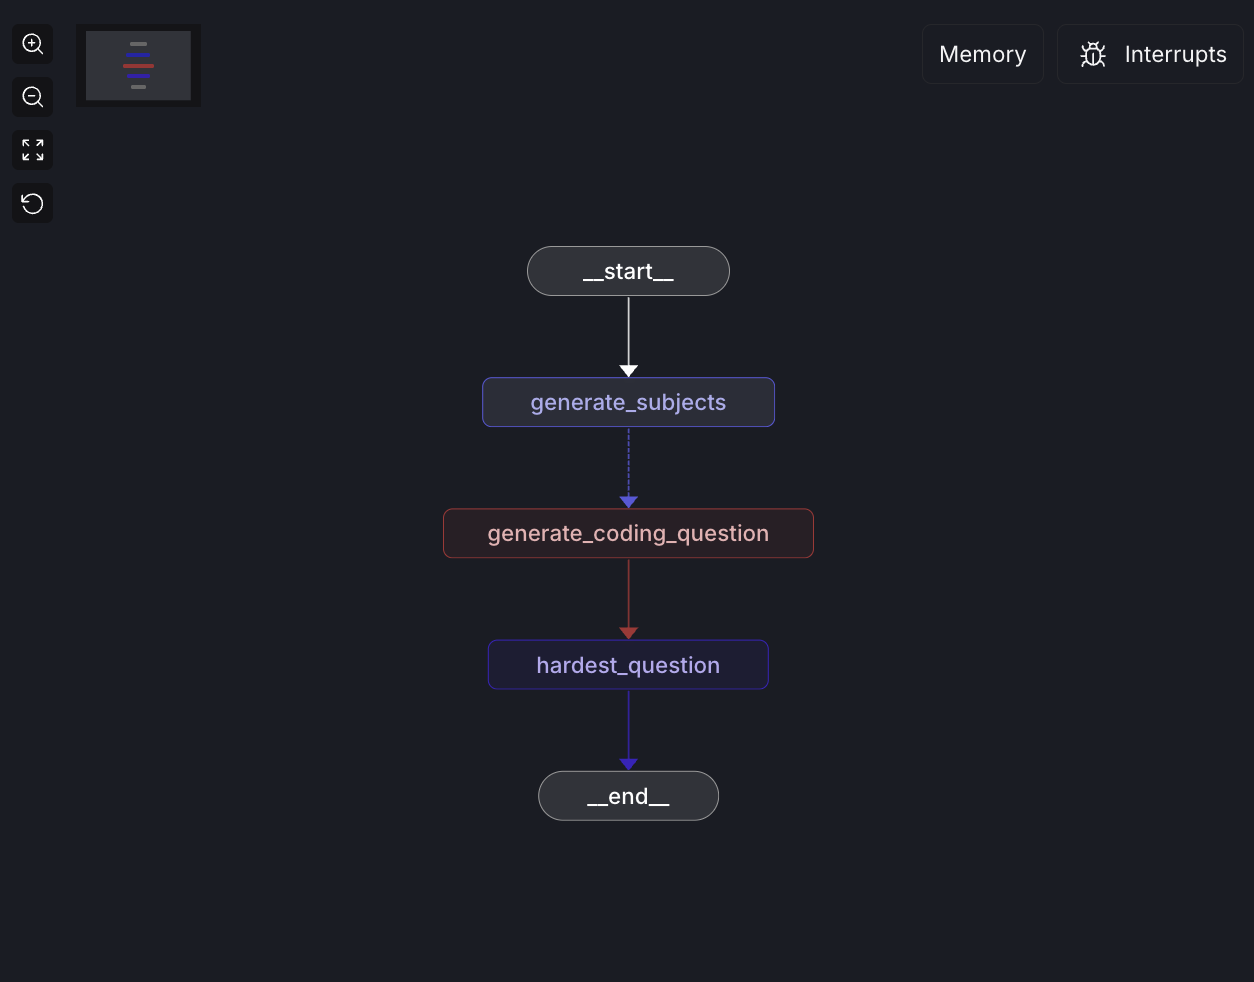

#### 1st step, genearting the subjects for the coding questions :

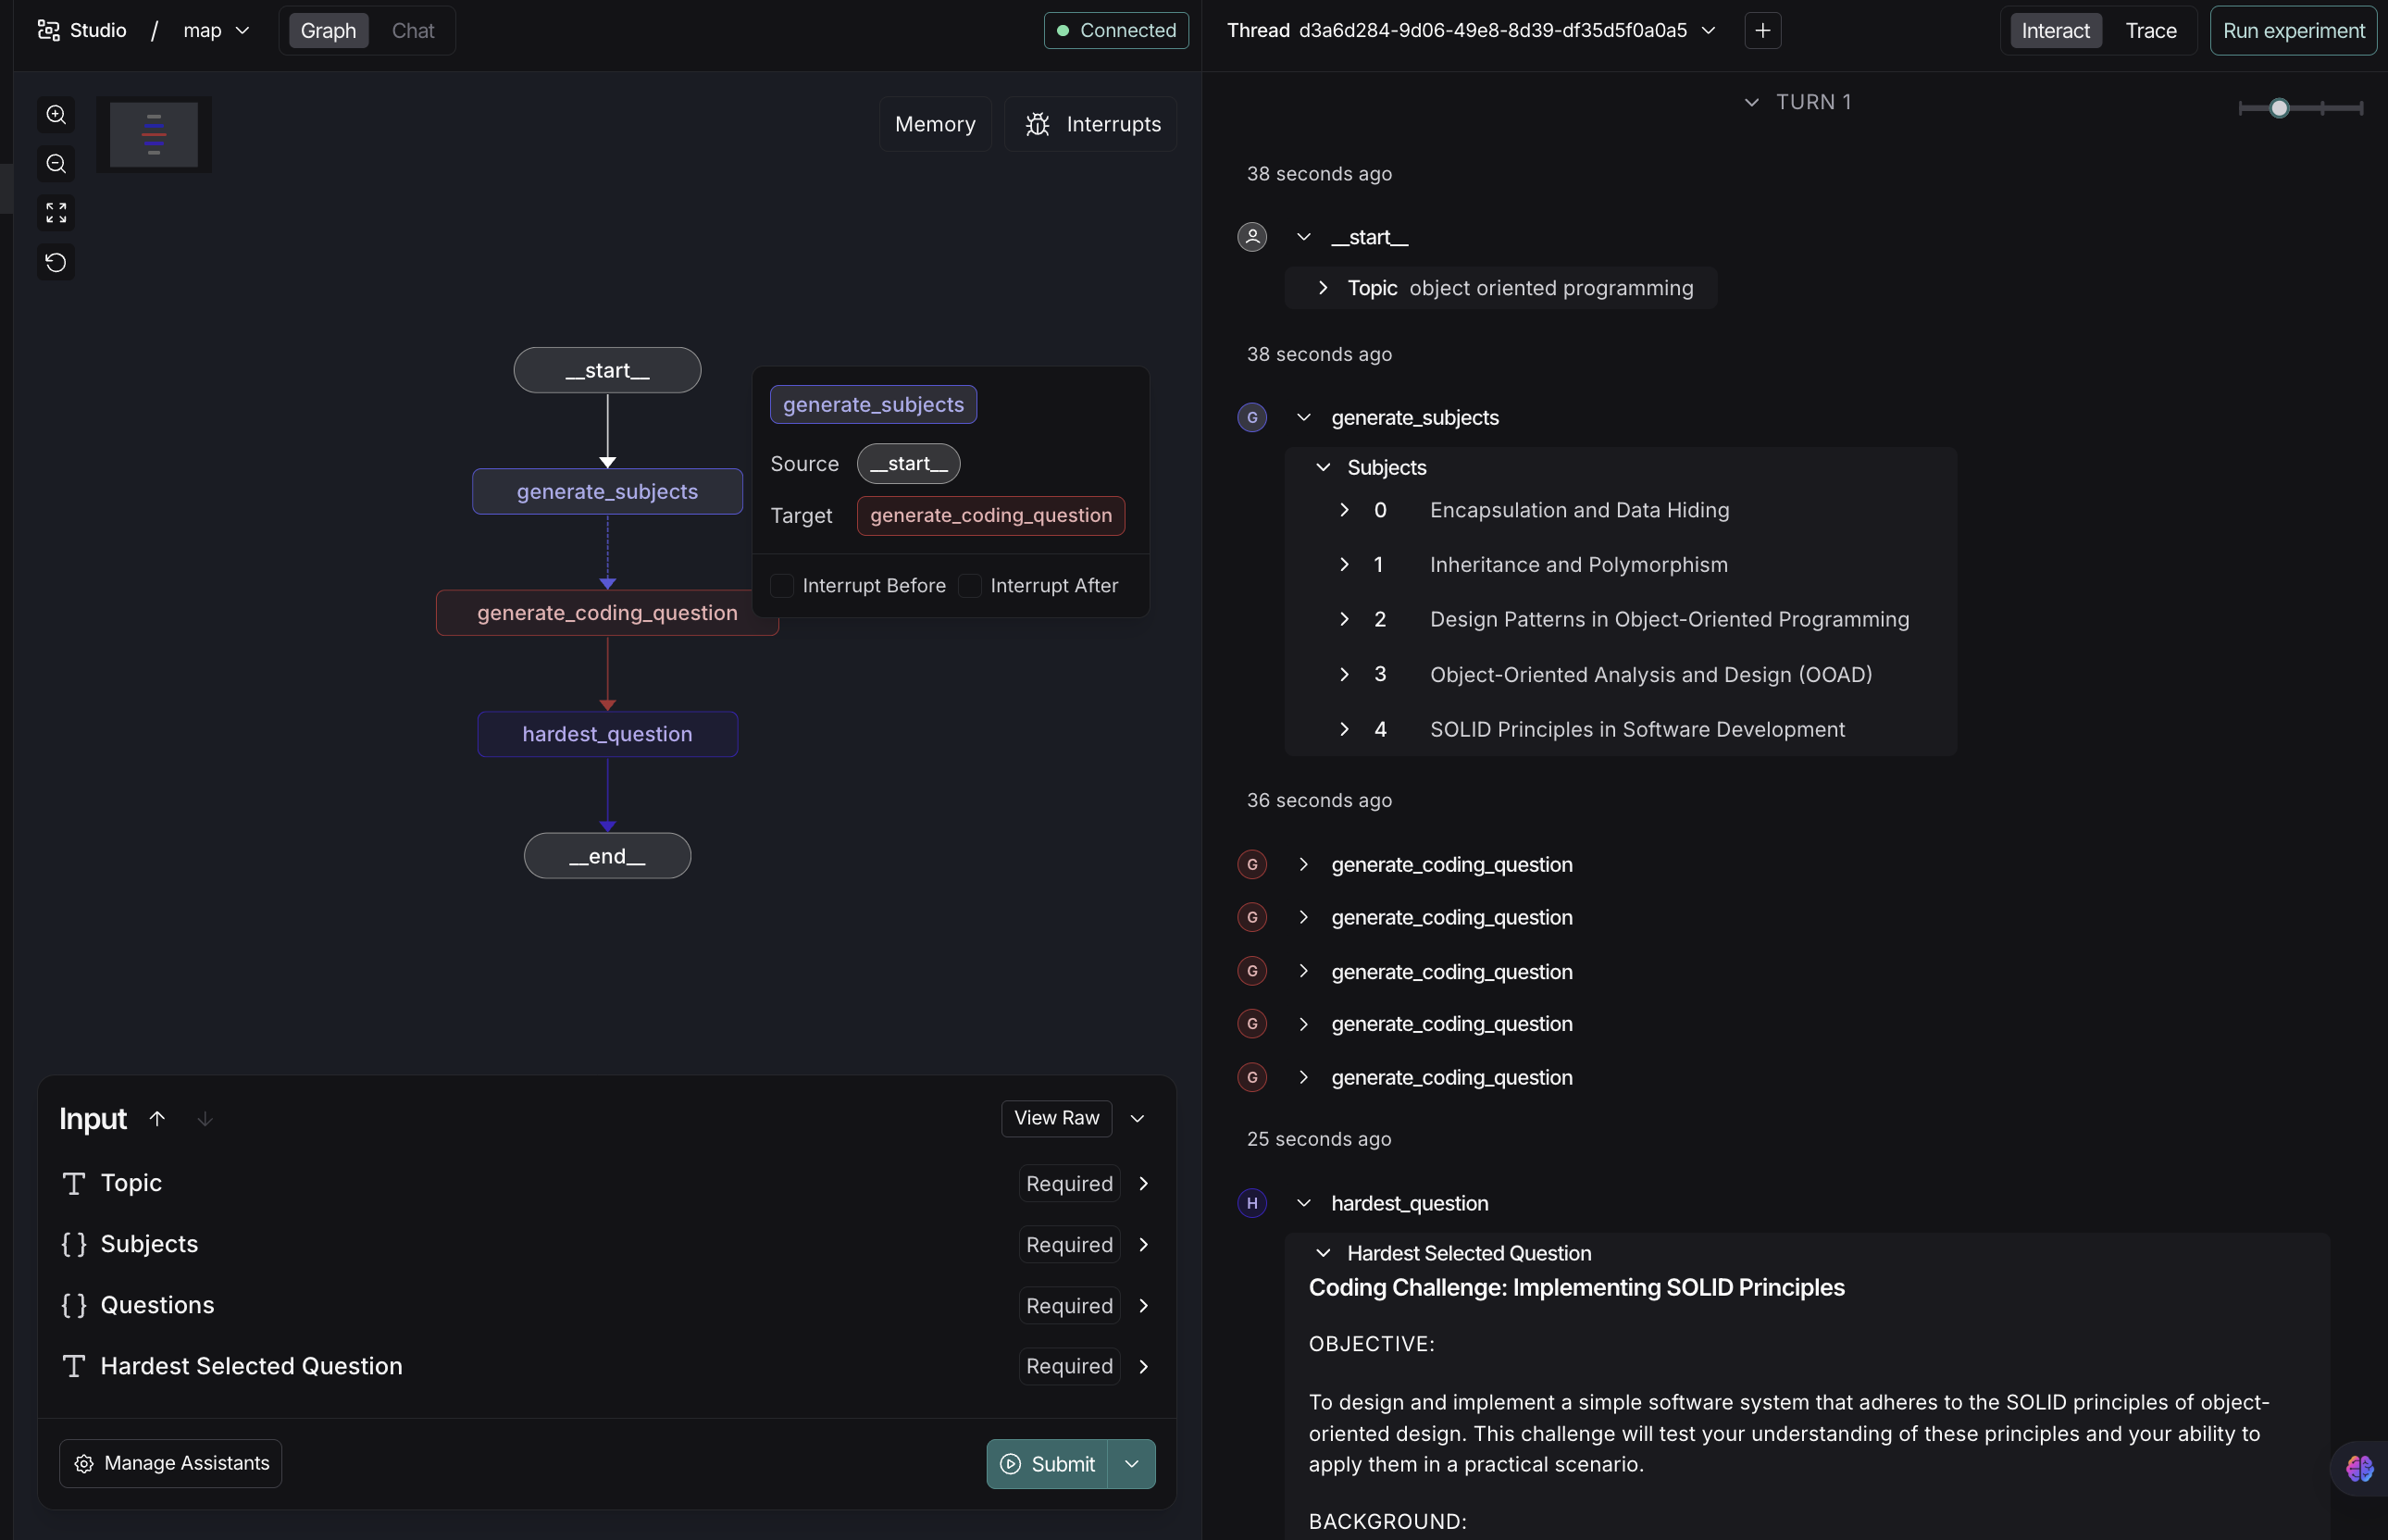

#### then in the next step it generstes 5 coding questions simultaneously , based on the subjects 

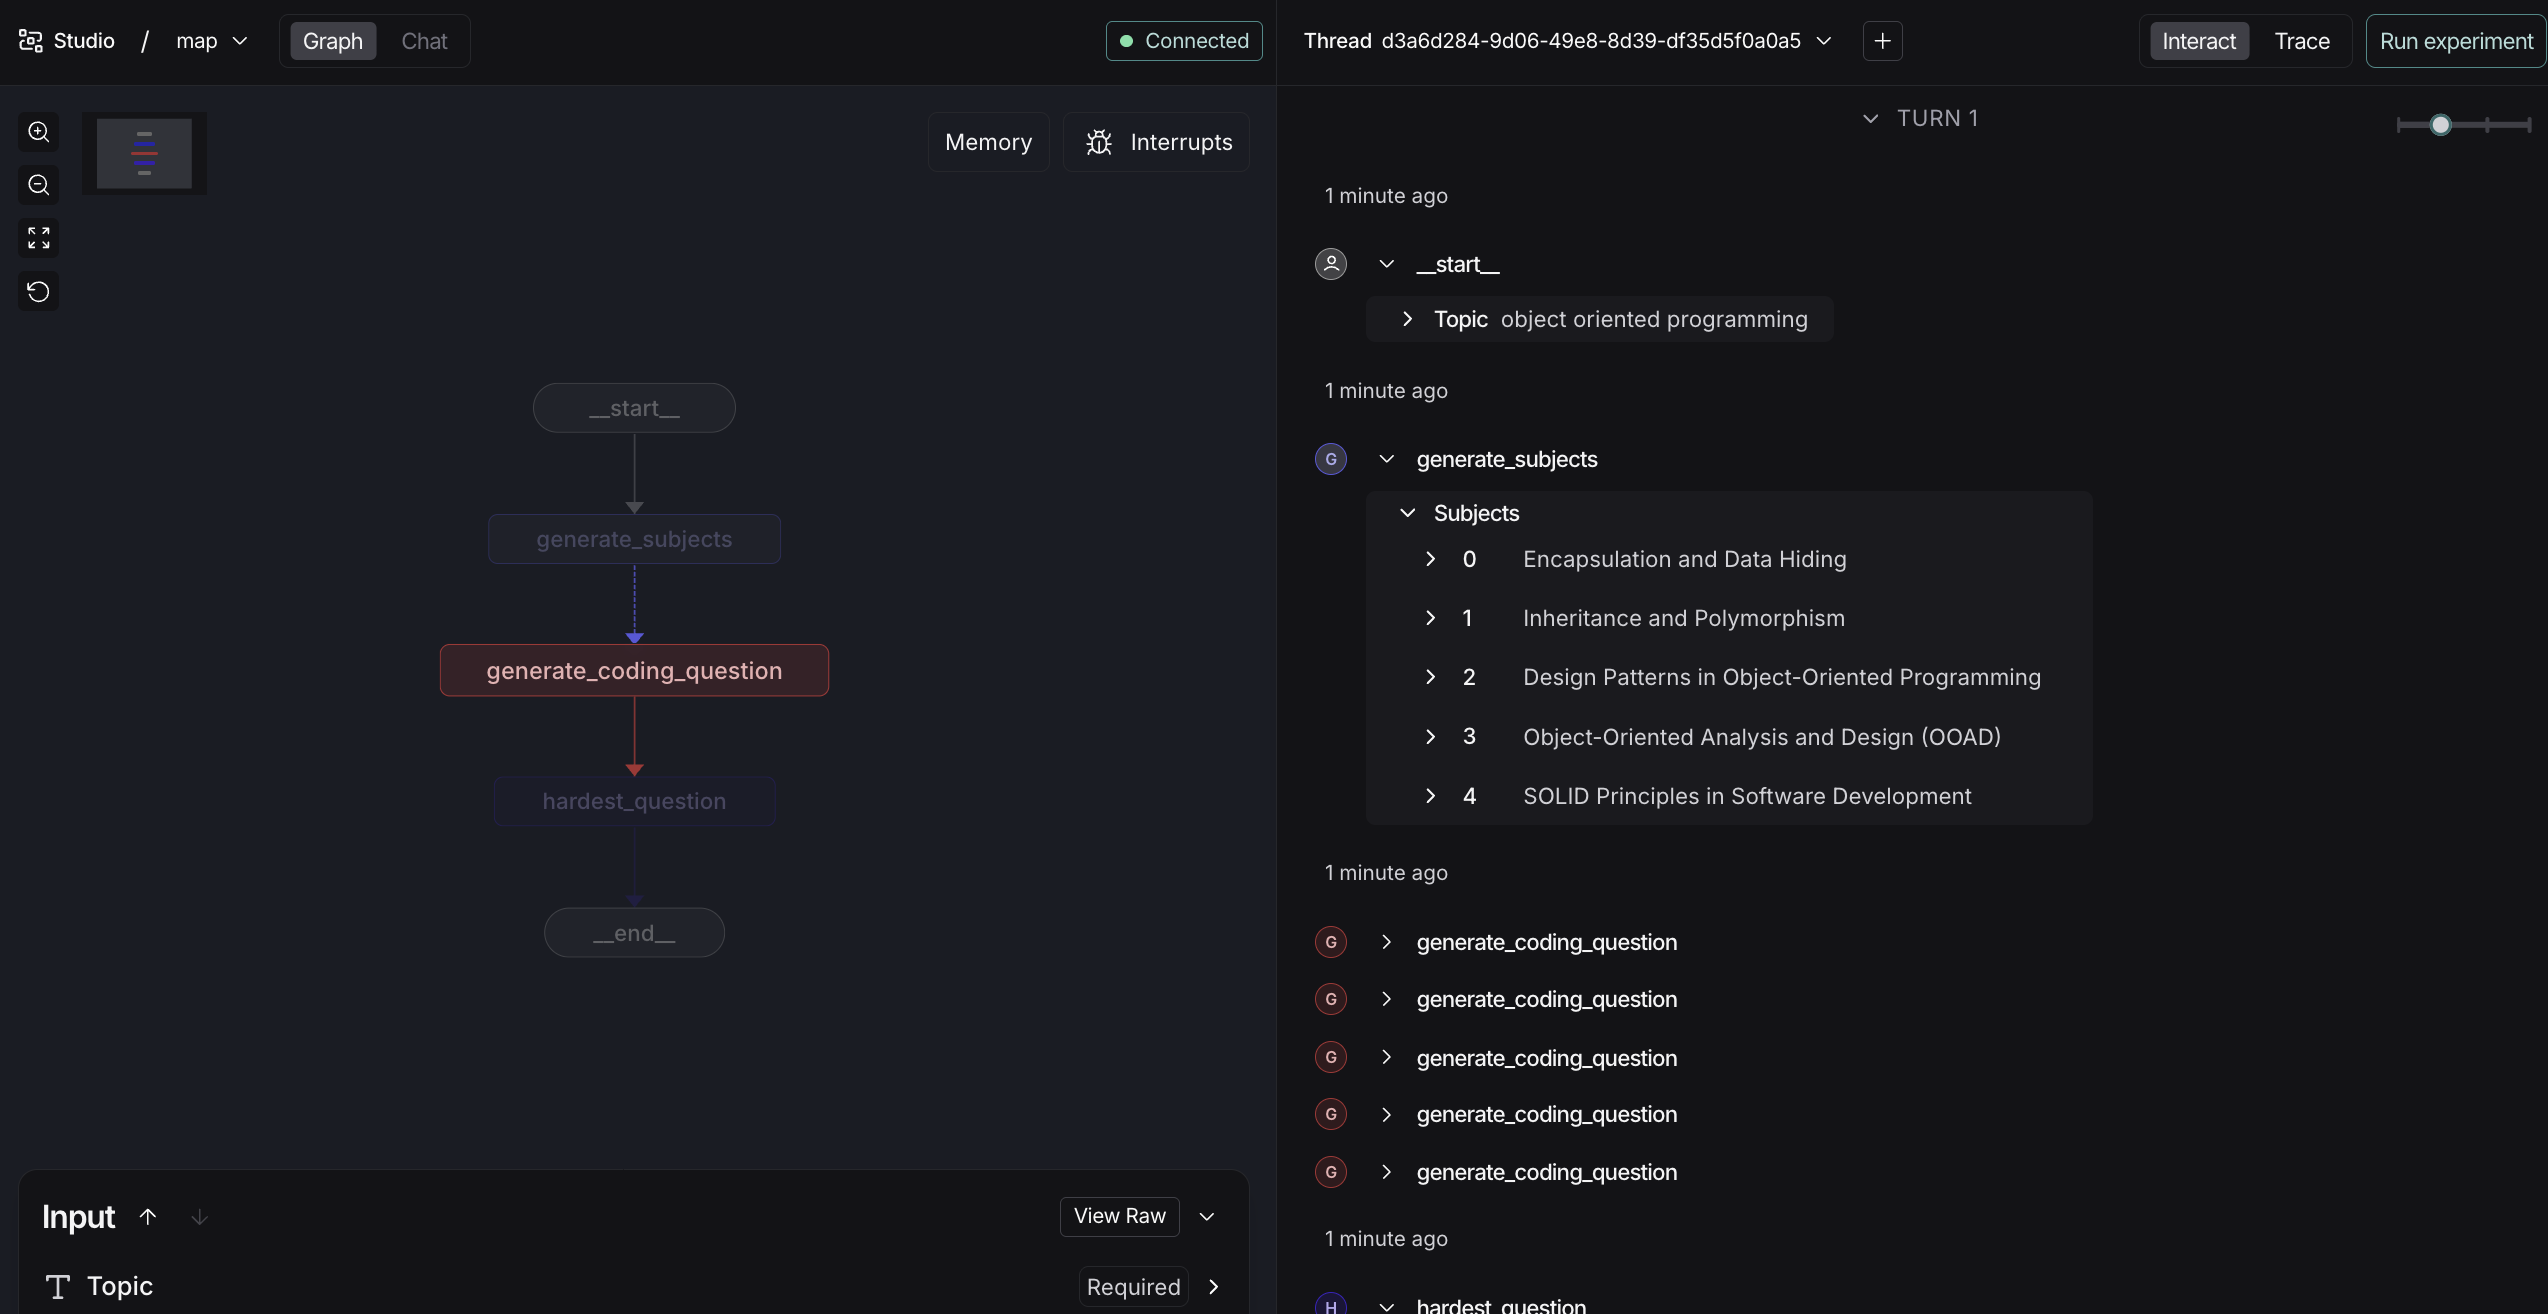

#### then the llm chooses the hardest one amongst them in the last step :

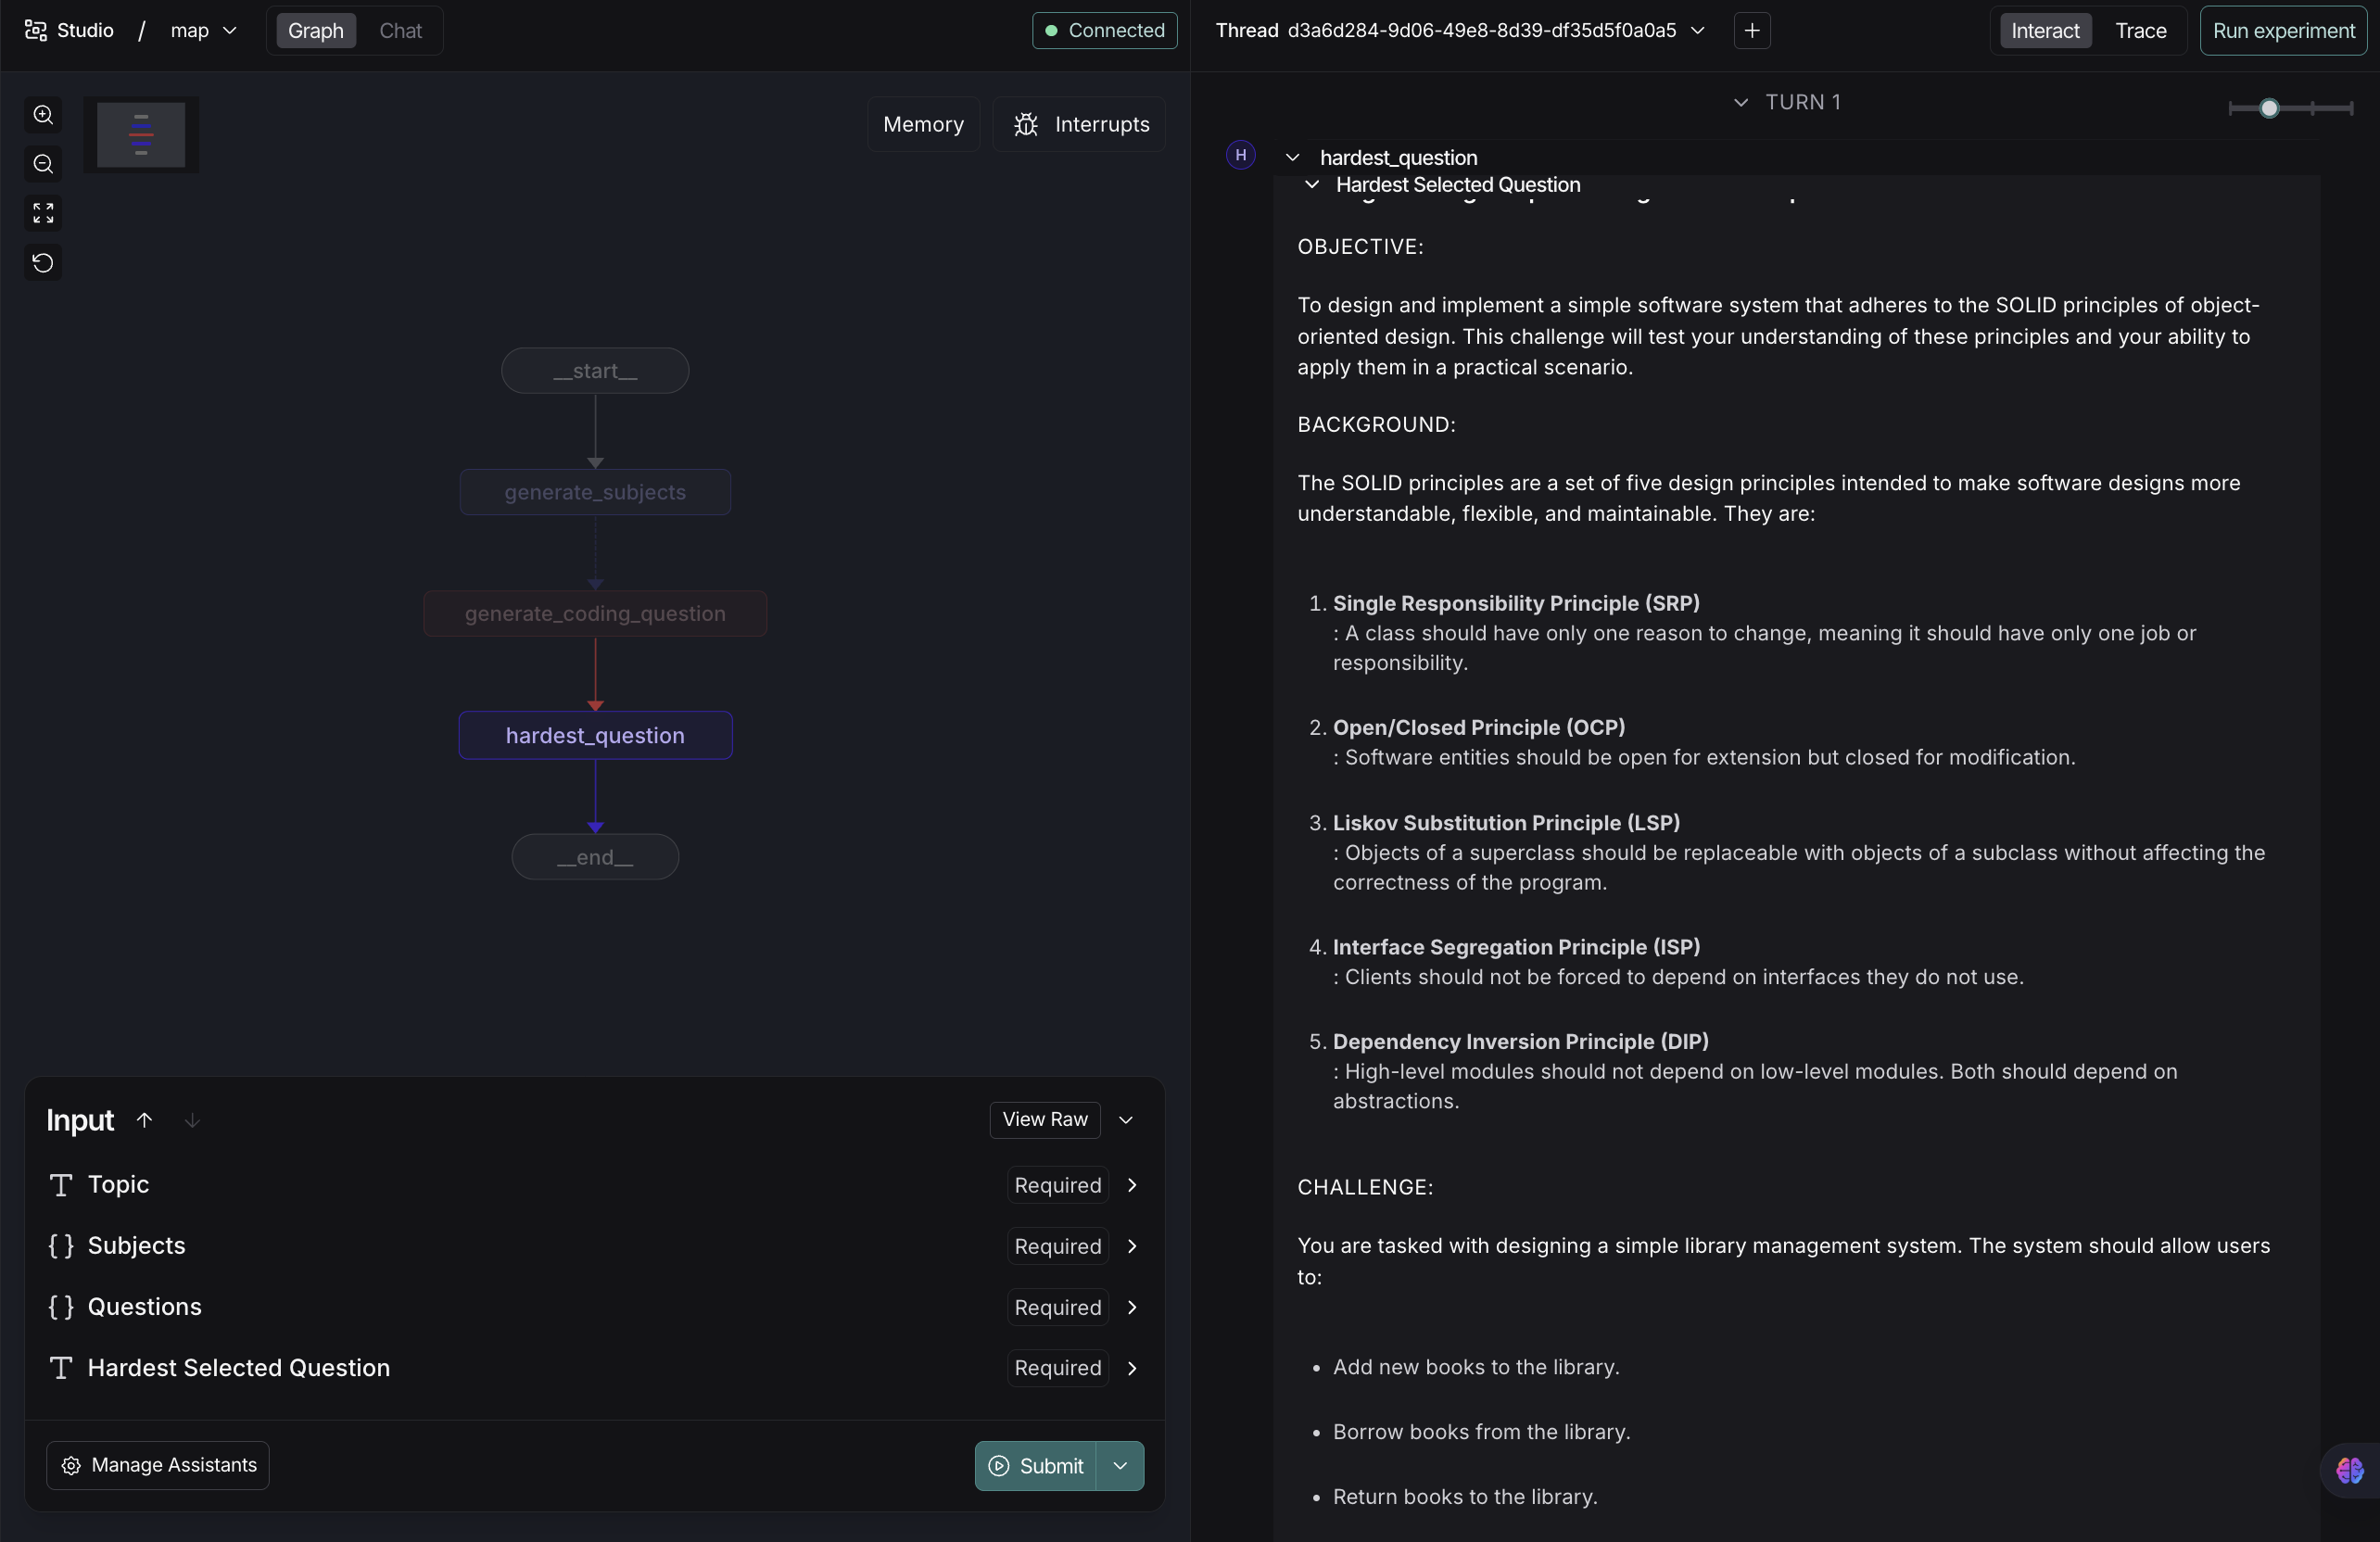